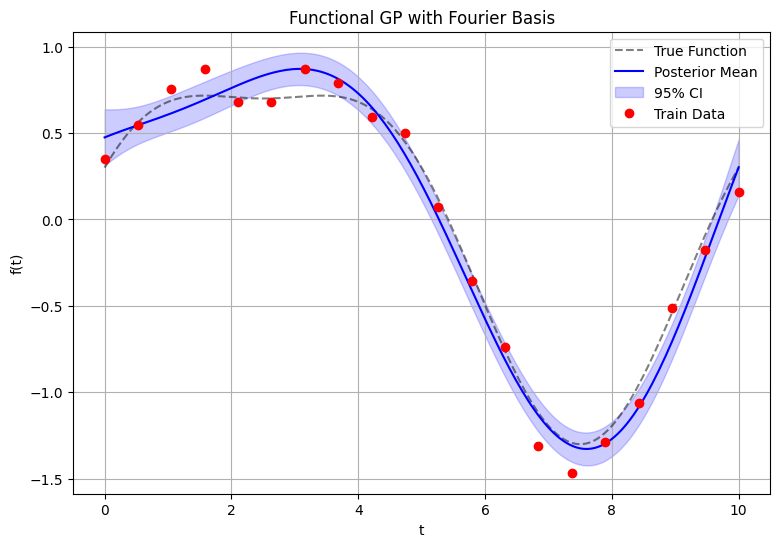

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 1. 기저함수(basis functions) 정의
#    예시: 간단한 Fourier 기저 (sin, cos)
# ---------------------------------------------------
def fourier_basis(t, M=3, L=10.0):
    """
    t:  (N,) or (N,1) shape의 시간축
    M:  사용할 base frequency의 개수
    L:  주기 스케일 (Fourier의 기본 길이)
    
    return: Phi (N, 2*M) shape
            [ sin(π t / L), cos(π t / L), ..., sin(Mπ t / L), cos(Mπ t / L) ]
    """
    t = np.array(t).flatten()
    N = len(t)
    Phi = []
    for m in range(1, M+1):
        Phi.append(np.sin(m * np.pi * t / L))
        Phi.append(np.cos(m * np.pi * t / L))
    Phi = np.stack(Phi, axis=1)  # (N, 2M)
    return Phi

# ---------------------------------------------------
# 2. 데이터 생성
#    실제 함수: f(t) = sin(2πt/L) + 0.3cos(4πt/L) + 잡음
# ---------------------------------------------------
np.random.seed(42)

def true_func(t, L=10.0):
    return np.sin(2*np.pi*t/L) + 0.3*np.cos(4*np.pi*t/L)

# 관측점 (훈련) 생성
N_train = 20
t_train = np.linspace(0, 10, N_train)
f_train = true_func(t_train)
sigma_n = 0.1  # 관측 잡음 표준편차
y_train = f_train + sigma_n * np.random.randn(N_train)

# ---------------------------------------------------
# 3. 사전(prior) 정의
#    beta ~ N(0, alpha^2 I),  alpha^2=1.0
# ---------------------------------------------------
alpha2 = 1.0  # alpha^2(분산)
M = 3         # 주파수 개수
Phi_train = fourier_basis(t_train, M=M, L=10.0)  # (N_train, 2M)
D = Phi_train.shape[1]                           # 2M

# prior: beta ~ N(0, alpha^2 I_D)
# noise: e ~ N(0, sigma_n^2 I_N)

# ---------------------------------------------------
# 4. 사후(posterior) 계산
#    y = Phi_train @ beta + e
#    beta | y ~ N( post_mean, post_cov )
# ---------------------------------------------------
# 실제로는 공식:
# post_cov = ( (1/σ_n^2) Phi^T Phi + (1/alpha^2) I )^-1
# post_mean= post_cov * (1/σ_n^2) Phi^T y
# 편의상 alpha^2, σ_n^2를 직접 대입
I_D = np.eye(D)
I_N = np.eye(N_train)
A = (Phi_train.T @ Phi_train) / (sigma_n**2) + (I_D / alpha2)
post_cov = np.linalg.inv(A)
post_mean= post_cov @ (Phi_train.T @ y_train) / (sigma_n**2)

# ---------------------------------------------------
# 5. 새로운 t에 대한 예측(함수 추정)
#    f*(t*) = phi(t*)^T beta
#    beta ~ N(post_mean, post_cov)
# ---------------------------------------------------
N_test = 200
t_test = np.linspace(0, 10, N_test)
Phi_test = fourier_basis(t_test, M=M, L=10.0)  # (N_test, D)

# 예측의 평균:
# E[f*(t*)] = E[phi(t*)^T beta] = phi(t*)^T post_mean
f_mean = Phi_test @ post_mean  # (N_test,)

# 예측의 분산:
# Var[f*(t*)] = phi(t*)^T post_cov phi(t*)
f_var = np.sum( (Phi_test @ post_cov) * Phi_test, axis=1 )  # (N_test,)

# ---------------------------------------------------
# 6. 결과 시각화
# ---------------------------------------------------
plt.figure(figsize=(9,6))

# 실제 함수
plt.plot(t_test, true_func(t_test), 'k--', label="True Function", alpha=0.5)

# 예측 평균
plt.plot(t_test, f_mean, 'b-', label="Posterior Mean")

# 95% 신뢰구간
f_std = np.sqrt(f_var)
plt.fill_between(t_test, f_mean - 1.96*f_std, f_mean + 1.96*f_std,
                 color='blue', alpha=0.2, label="95% CI")

# 관측 데이터
plt.plot(t_train, y_train, 'ro', label="Train Data")

plt.xlabel("t")
plt.ylabel("f(t)")
plt.title("Functional GP with Fourier Basis")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
Phi.shape, Y.shape, X.shape

((10, 20), (20, 1), (20, 1))

In [27]:
(Phi @ Y).shape

(10, 1)

In [1]:
import os; os.chdir("../")

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader

from pnpxai.core.modality.modality import Modality
from pnpxai import AutoExplanation

from models.tab_resnet import TabResNet

2025-03-20 20:14:00.436890: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 20:14:00.451074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742469240.467226     355 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742469240.472149     355 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 20:14:00.488619: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
dataset_nm = "Wine Quality"
X_test = np.load(f"data/{dataset_nm}/X_test.npy")[:100]
test_input = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

In [4]:
use_gpu = True
test_loader = DataLoader(
    test_input,
    batch_size=32,
    shuffle=False,
    pin_memory=use_gpu,
)

In [5]:
model = TabResNet(X_test.shape[1], 2, num_blocks=1)
model.load_state_dict(torch.load(f"data/{dataset_nm}/resnet_model.pth"))
model.eval()

def squeeze_hook(module, input):
    return input[0].squeeze(1)

model.register_forward_pre_hook(squeeze_hook)

sample_batch = next(iter(test_loader))
modality = Modality(
    dtype=sample_batch[0].dtype,
    ndims=2,
    pooling_dim=1
)

In [6]:
expr = AutoExplanation(
    model=model,
    data=test_loader,
    modality=modality,
    target_input_keys=[0], # Current test_loader batches data as tuple of (inputs, targets). 0 means the location of inputs in the tuple
    target_class_extractor=lambda outputs: outputs.argmax(-1),
    label_key='labels',
    target_labels=False, # Gets attributions on the prediction for all explainer if False.
)

In [7]:
import pandas as pd
from tqdm import tqdm
import itertools
from collections import defaultdict

# You can browse available explainer_keys and metric_keys as followings:
print(expr.explainers.choices)
print(expr.metrics.choices)

# optimize all
fast_dev_run = True
records = []
best_params = defaultdict(dict)
combs = list(itertools.product(
    expr.explainers.choices,
    expr.metrics.choices,
))
pbar = tqdm(combs, total=len(combs))
for explainer_key, metric_key in pbar:
    if expr.is_tunable(explainer_key): # skip if there's no tunable for an explainer
        pbar.set_description(f'Optimizing {explainer_key} on {metric_key}')
        direction = {
            'mo_r_f': 'minimize',
            'le_r_f': 'maximize',
            'ab_p_c': 'maximize',
        }.get(metric_key)
        opt_results = expr.optimize(
            explainer_key=explainer_key,
            metric_key=metric_key,
            direction=direction,
            sampler='random',
            seed=42,
            num_threads=16,
            show_progress=not fast_dev_run,
            n_trials=2 if fast_dev_run else 100,
        )
        records.append({
            'explainer': explainer_key,
            'metric': f'Best {metric_key}',
            'value': opt_results.study.best_trial.value,
        })
        best_params[explainer_key][metric_key] = opt_results.study.best_params
df = pd.DataFrame.from_records(records)
summary_table = df.set_index(
    ['explainer', 'metric'])['value'].unstack('metric')
print('-------- Summary --------')
print(summary_table)
print('------ Best Params ------')
print(best_params)

['gradient', 'gradient_x_input', 'integrated_gradients', 'kernel_shap', 'l_r_p_uniform_epsilon', 'lime', 'smooth_grad', 'var_grad']
['mo_r_f', 'le_r_f', 'ab_p_c']


Optimizing integrated_gradients on mo_r_f:   0%|          | 0/24 [00:00<?, ?it/s][I 2025-03-20 20:14:03,209] A new study created in memory with name: no-name-6675e84f-9344-4447-a0fa-583a13cadff6
[I 2025-03-20 20:14:03,260] Trial 0 finished with value: 0.023114497661590575 and parameters: {'n_steps': 40, 'baseline_fn': 'zeros', 'pooling_method': 'identity', 'normalization_method': 'identity'}. Best is trial 0 with value: 0.023114497661590575.
[I 2025-03-20 20:14:03,306] Trial 1 finished with value: 0.023114497661590575 and parameters: {'n_steps': 60, 'baseline_fn': 'zeros', 'pooling_method': 'identity', 'normalization_method': 'identity'}. Best is trial 0 with value: 0.023114497661590575.
Optimizing integrated_gradients on le_r_f:  29%|██▉       | 7/24 [00:00<00:00, 50.33it/s][I 2025-03-20 20:14:03,329] A new study created in memory with name: no-name-f255cb90-08da-4ecd-aaac-1e3d6f518404
[I 2025-03-20 20:14:03,371] Trial 0 finished with value: 0.027964032888412475 and parameters: {'n_st

-------- Summary --------
metric                 Best ab_p_c  Best le_r_f  Best mo_r_f
explainer                                                   
integrated_gradients      0.004850     0.027964     0.023114
kernel_shap               0.004497     0.027682     0.023770
l_r_p_uniform_epsilon    -0.000391     0.026484     0.026784
lime                      0.003052     0.027784     0.023859
smooth_grad              -0.002099     0.025329     0.027330
var_grad                  0.002007     0.027393     0.025291
------ Best Params ------
defaultdict(<class 'dict'>, {'integrated_gradients': {'mo_r_f': {'n_steps': 40, 'baseline_fn': 'zeros', 'pooling_method': 'identity', 'normalization_method': 'identity'}, 'le_r_f': {'n_steps': 40, 'baseline_fn': 'zeros', 'pooling_method': 'identity', 'normalization_method': 'identity'}, 'ab_p_c': {'n_steps': 40, 'baseline_fn': 'zeros', 'pooling_method': 'identity', 'normalization_method': 'identity'}}, 'kernel_shap': {'mo_r_f': {'n_samples': 30, 'baseline_

In [10]:
print(expr.explainers.choices)
print(expr.metrics.choices)



for exp in expr.explainers.choices:
    for met in expr.metrics.choices:
        record = np.zeros_like(X_test)
        for i in range(X_test.shape[0]):
            output = expr.run_batch(
                explainer_key=exp,
                metric_key=met,
                data_ids=[i],
            )
            record[i] = output.explanations.detach().cpu().numpy()

        break

['gradient', 'gradient_x_input', 'integrated_gradients', 'kernel_shap', 'l_r_p_uniform_epsilon', 'lime', 'smooth_grad', 'var_grad']
['mo_r_f', 'le_r_f', 'ab_p_c']


In [11]:
record

array([[ 0.02665017, -0.04030741,  0.00754313, ...,  0.0304978 ,
         0.04132595,  0.09259082],
       [ 0.03633024, -0.06769688, -0.01895781, ..., -0.01557442,
         0.01260411,  0.07034592],
       [ 0.00808559, -0.0254424 , -0.0141538 , ...,  0.01486275,
         0.02052409,  0.05516587],
       ...,
       [ 0.0871587 , -0.05095329,  0.08084942, ...,  0.02136874,
         0.12035432,  0.19896185],
       [ 0.04139544, -0.05688661,  0.0430186 , ...,  0.05557824,
         0.05693781,  0.17586356],
       [ 0.00127309, -0.00528111,  0.00289649, ...,  0.00043834,
         0.00535086,  0.0083477 ]])

In [ ]:
expr.explainers

In [ ]:
output = expr.run_batch(explainer_key="gradient", metric_key="mo_r_f", data_ids=[1])

In [ ]:
output.explanations

tensor([[-0.0502,  0.0766,  0.0242, -0.0244, -0.0192,  0.0059,  0.0586,  0.0322,
          0.0281, -0.0069, -0.0653]])

In [ ]:
expr.manager._cache.get_explanation(1, "gradient")

In [ ]:
output.explanations

tensor([[-0.0196,  0.0445,  0.0006, -0.0678,  0.0001, -0.0545,  0.0386,  0.0396,
         -0.0225, -0.0353, -0.0791]])

In [ ]:
STOP

NameError: name 'STOP' is not defined

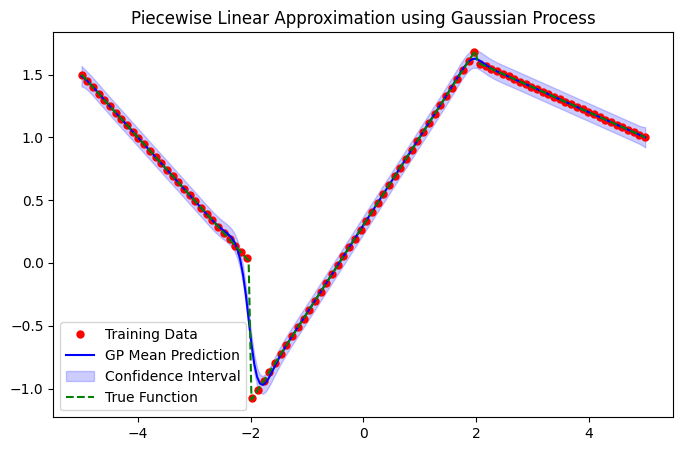

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, DotProduct

# Piecewise Linear한 함수 정의
def true_function(x):
    return np.piecewise(x, 
                        [x < -2, (x >= -2) & (x < 2), x >= 2],
                        [lambda x: -0.5*x - 1,
                         lambda x: 0.7*x + 0.3,
                         lambda x: -0.2*x + 2])

# 데이터 생성
X = np.linspace(-5, 5, 100).reshape(-1, 1)
y = true_function(X[:, 0])

# Piecewise Linear 근사화 위한 커널 설정
kernel = (
    ConstantKernel(1.0) * Matern(length_scale=1.0, nu=1.5) +  # 구간 내 선형 근사
    WhiteKernel(noise_level=0.1) +                            # 노이즈 추가로 부드러움 감소
    DotProduct(sigma_0=1.0)                                    # 선형적 성질 강화
)

# Gaussian Process 설정
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=10)

# 모델 학습
gp.fit(X, y)

# 예측 수행
X_test = np.linspace(-5, 5, 200).reshape(-1, 1)
y_mean, y_std = gp.predict(X_test, return_std=True)

# 결과 시각화
plt.figure(figsize=(8, 5))
plt.plot(X, y, 'r.', markersize=10, label="Training Data")
plt.plot(X_test, y_mean, 'b-', label="GP Mean Prediction")
plt.fill_between(X_test[:, 0], 
                 y_mean - y_std, 
                 y_mean + y_std, 
                 alpha=0.2, color='blue', label="Confidence Interval")
plt.plot(X_test, true_function(X_test[:, 0]), 'g--', label="True Function")
plt.legend()
plt.title("Piecewise Linear Approximation using Gaussian Process")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF
from torch.utils.data._utils.collate import default_collate
from torch.utils.data import DataLoader
from pnpxai import AutoExplanationForImageClassification

from helpers import get_imagenet_dataset, get_torchvision_model, denormalize_image

import torch.nn as nn
import torch.nn.functional as F
import torchvision

# ------------------------------------------------------------------------------#
# -------------------------------- basic usage ---------------------------------#
# ------------------------------------------------------------------------------#

# setup
torch.set_num_threads(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, transform = get_torchvision_model('resnet18')
dataset = get_imagenet_dataset(transform, indices=range(1000))
loader = DataLoader(dataset, batch_size=4, shuffle=False)

# create auto explanation
expr = AutoExplanationForImageClassification(
    model=model.to(device),
    data=loader,
    input_extractor=lambda batch: batch[0].to(device),
    label_extractor=lambda batch: batch[-1].to(device),
    target_extractor=lambda outputs: outputs.argmax(-1).to(device),
    target_labels=False,  # target prediction if False
)


/home/cwl/repo/pnpxai/pnpxai/evaluator/metrics/sensitivity.py:39: UserWarning: [Sensitivity] explainer is not provided. Please set explainer before evaluate.
  warnings.warn('[Sensitivity] explainer is not provided. Please set explainer before evaluate.')


In [ ]:
# browse the recommended
# expr.recommended.print_tabular()  # recommendation
# expr.recommended.explainers  # -> List[Type[Explainer]]

# browse explainers and metrics
# expr.manager.explainers  # -> List[Explainer]
# expr.manager.metrics  # -> List[Metric]

# -> Explainer. In this case, LRPEpsilonGammaBox
expr.manager.get_explainer_by_id(11)
# -> PostProcessor. In this case, PostProcessor(pooling_method='sumpos', normalization_method='minmax')
# expr.manager.get_postprocessor_by_id(1)
# expr.manager.get_metric_by_id(0)  # -> Metric. In this case, AbPC



SmoothGrad(noise_level=0.1, n_iter=20)

In [ ]:
data_id = 668
metric_id = 1
explainer_id = 11

In [ ]:
expr.manager.get_metric_by_id(1)

AbPC(channel_dim=1, n_steps=10, baseline_fn=<pnpxai.explainers.utils.baselines.ZeroBaselineFunction object at 0x7f70b39aff40>, lb=-1.0)

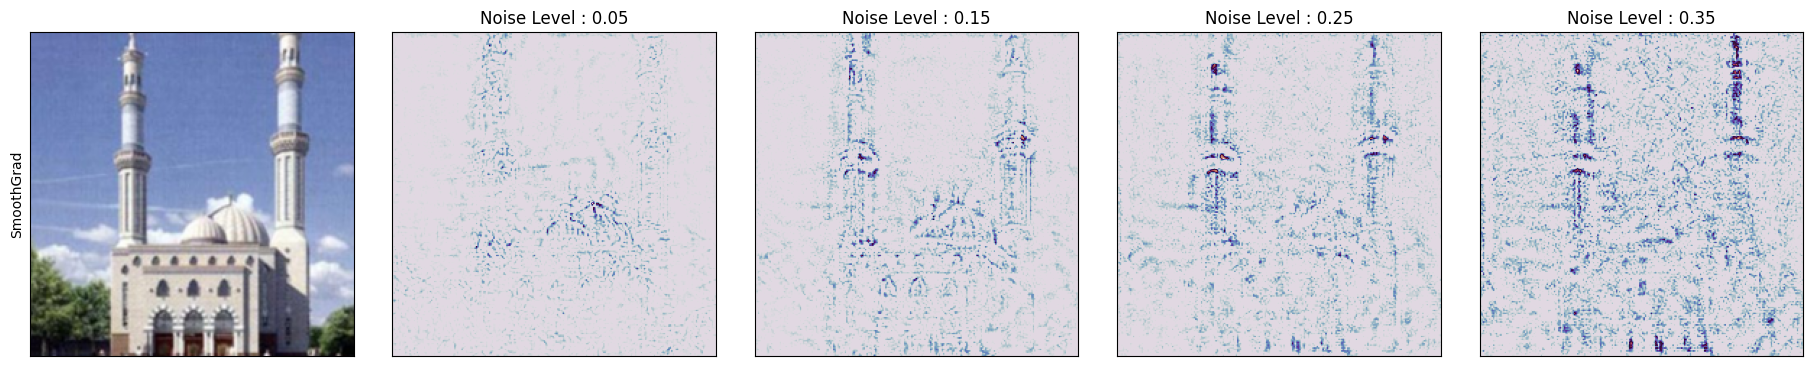

In [ ]:
# explain and evaluate
n_explainers = 1
edge_size = 4


explainer_nm = expr.manager.get_explainer_by_id(explainer_id).__class__.__name__

data = expr.manager.batch_data_by_ids(data_ids=[data_id])
inputs = expr.input_extractor(data)
labels = expr.label_extractor(data)

# vis explanations
params = [0.05, 0.15, 0.25, 0.35]
fig, axes = plt.subplots(n_explainers, (len(params)+1), figsize=(edge_size*(len(params)+1), edge_size))

# vis inputs
r = 0
axes[0].imshow(
    denormalize_image(
        inputs[0].detach().cpu(),
        mean=transform.mean,
        std=transform.std,
))
axes[0].set_ylabel(explainer_nm)

explainer = expr.manager.get_explainer_by_id(11)
explainer = explainer.set_kwargs(n_iter=100)
postprocessor = expr.manager.get_postprocessor_by_id(0)
metric = expr.manager.get_metric_by_id(1)
for c, param in enumerate(params, 1):
    explainer = explainer.set_kwargs(noise_level=param)
    attrs = explainer.attribute(inputs, labels)
    pps = postprocessor(attrs)

    metric.explainer = explainer
    eval_res = metric.evaluate(inputs, labels, attrs)
    axes[c].imshow(pps[0].detach().cpu(), cmap='twilight')
    if r == 0:
        axes[c].set_title(f"Noise Level : {param:.2f}")

fig.subplots_adjust(wspace=-.5, hspace=-.5)
fig.tight_layout()

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

# plt.savefig('auto_explanation_imagenet_example.png')
plt.show()

In [ ]:
expr.manager.postprocessors[0]

In [ ]:
eval_res.item()

0.10020073503255844

In [ ]:
STOP

[I 2024-11-15 17:44:12,398] A new study created in memory with name: no-name-bfe38fa2-0614-409f-91d3-5df0611e7406
[I 2024-11-15 17:44:13,658] Trial 0 finished with value: 0.17567448318004608 and parameters: {'explainer.noise_level': 0.4, 'explainer.n_iter': 100, 'postprocessor.pooling_fn.method': 'posl2normsq', 'postprocessor.normalization_fn.method': 'minmax'}. Best is trial 0 with value: 0.17567448318004608.
[I 2024-11-15 17:44:13,972] Trial 1 finished with value: 0.5413512587547302 and parameters: {'explainer.noise_level': 0.2, 'explainer.n_iter': 20, 'postprocessor.pooling_fn.method': 'posl2normsq', 'postprocessor.normalization_fn.method': 'identity'}. Best is trial 1 with value: 0.5413512587547302.
[I 2024-11-15 17:44:14,175] Trial 2 finished with value: 0.06877031922340393 and parameters: {'explainer.noise_level': 0.6000000000000001, 'explainer.n_iter': 10, 'postprocessor.pooling_fn.method': 'l2norm', 'postprocessor.normalization_fn.method': 'identity'}. Best is trial 1 with valu

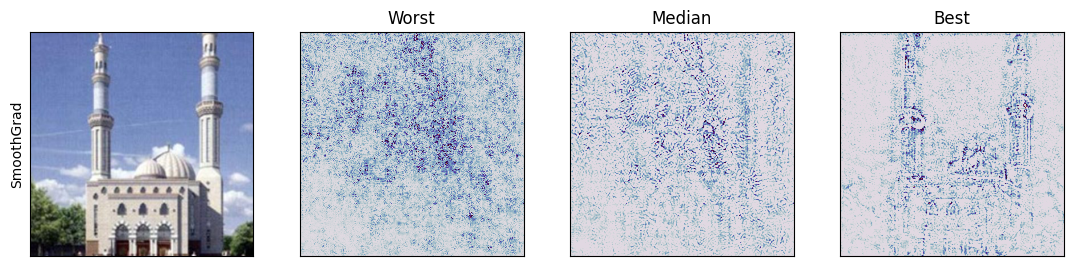

In [ ]:
# explain and evaluate
n_explainers = 1
edge_size = 3
fig, axes = plt.subplots(n_explainers, 4, figsize=(edge_size*4, edge_size*n_explainers))


explainer_nm = expr.manager.get_explainer_by_id(explainer_id).__class__.__name__

# optimize
optimized = expr.optimize(
    data_ids=data_id,
    explainer_id=explainer_id,
    metric_id=metric_id,
    direction='maximize',
    sampler='random',
    n_trials=50,
    seed=42,
)

# prepare trials to visualize
sorted_trials = sorted(
    [trial for trial in optimized.study.trials if trial.value is not None],
    key=lambda trial: trial.value,
)
trials_to_vis = {
    'Worst': sorted_trials[0],
    'Median': sorted_trials[len(sorted_trials)//2],
    'Best': sorted_trials[-1],
}

data = expr.manager.batch_data_by_ids(data_ids=[data_id])
inputs = expr.input_extractor(data)
labels = expr.label_extractor(data)

# vis inputs
r = 0
axes[0].imshow(
    denormalize_image(
        inputs[0].detach().cpu(),
        mean=transform.mean,
        std=transform.std,
))
axes[0].set_ylabel(explainer_nm)

# vis explanations
for c, (title, trial) in enumerate(trials_to_vis.items(), 1):
    explainer = trial.user_attrs['explainer']
    postprocessor = trial.user_attrs['postprocessor']

    attrs = explainer.attribute(inputs, labels)
    pps = postprocessor(attrs)
    axes[c].imshow(pps[0].detach().cpu(), cmap='twilight')
    if r == 0:
        axes[c].set_title(title)

fig.subplots_adjust(wspace=-.5, hspace=-.5)
fig.tight_layout()

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

# plt.savefig('auto_explanation_imagenet_example.png')
plt.show()

In [ ]:
sorted_trials

[FrozenTrial(number=37, state=TrialState.COMPLETE, values=[-0.020832737907767296], datetime_start=datetime.datetime(2024, 11, 15, 16, 53, 26, 651747), datetime_complete=datetime.datetime(2024, 11, 15, 16, 53, 26, 953831), params={'explainer.noise_level': 0.95, 'explainer.n_iter': 20, 'postprocessor.pooling_fn.method': 'l1norm', 'postprocessor.normalization_fn.method': 'identity'}, user_attrs={'explainer': SmoothGrad(noise_level=0.95, n_iter=20), 'postprocessor': <pnpxai.explainers.utils.postprocess.PostProcessor object at 0x7f304cb5ce50>}, system_attrs={}, intermediate_values={}, distributions={'explainer.noise_level': FloatDistribution(high=0.95, log=False, low=0.05, step=0.05), 'explainer.n_iter': IntDistribution(high=100, log=False, low=10, step=10), 'postprocessor.pooling_fn.method': CategoricalDistribution(choices=('sumpos', 'sumabs', 'l1norm', 'maxnorm', 'l2norm', 'l2normsq', 'possum', 'posmaxnorm', 'posl2norm', 'posl2normsq')), 'postprocessor.normalization_fn.method': Categorica

In [ ]:
STOP

/home/cwl/repo/pnpxai/pnpxai/evaluator/metrics/sensitivity.py:39: UserWarning: [Sensitivity] explainer is not provided. Please set explainer before evaluate.
  warnings.warn('[Sensitivity] explainer is not provided. Please set explainer before evaluate.')


----------------------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
detected_architectures  ['Convolution', 'Linear']
explainers              ['GradCam', 'Gradient', 'GradientXInput', 'GuidedGradCam', 'IntegratedGradients', 'KernelShap', 'LRPEpsilonAlpha2Beta1', 'LRPEpsilonGammaBox', 'LRPEpsilonPlus', 'LRPUniformEpsilon', 'Lime', 'SmoothGrad', 'VarGrad']
----------------------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


[I 2024-11-15 16:30:26,600] A new study created in memory with name: no-name-a7f0d7b7-1383-476c-be22-93185d72f3b3
[I 2024-11-15 16:30:27,537] Trial 0 finished with value: 0.3913867175579071 and parameters: {'explainer.n_steps': 40, 'explainer.baseline_fn.method': 'zeros', 'postprocessor.pooling_fn.method': 'possum', 'postprocessor.normalization_fn.method': 'identity'}. Best is trial 0 with value: 0.3913867175579071.
[I 2024-11-15 16:30:27,867] Trial 1 finished with value: 0.3544221520423889 and parameters: {'explainer.n_steps': 60, 'explainer.baseline_fn.method': 'invert', 'postprocessor.pooling_fn.method': 'maxnorm', 'postprocessor.normalization_fn.method': 'identity'}. Best is trial 0 with value: 0.3913867175579071.
[I 2024-11-15 16:30:28,136] Trial 2 finished with value: 0.381294310092926 and parameters: {'explainer.n_steps': 100, 'explainer.baseline_fn.method': 'zeros', 'postprocessor.pooling_fn.method': 'l2norm', 'postprocessor.normalization_fn.method': 'identity'}. Best is trial 

Best/Explainer: IntegratedGradients(n_steps=80, baseline_fn=<pnpxai.explainers.utils.baselines.ZeroBaselineFunction object at 0x7f62686bd120>)
Best/PostProcessor: <pnpxai.explainers.utils.postprocess.PostProcessor object at 0x7f62686bd030>
Best/value: 0.45854315161705017
25th Trial/Explainer IntegratedGradients(n_steps=90, baseline_fn=<pnpxai.explainers.utils.baselines.ZeroBaselineFunction object at 0x7f6268687880>)
25th Trial/PostProcessor <pnpxai.explainers.utils.postprocess.PostProcessor object at 0x7f62686cf760>
25th Trial/value 0.44938236474990845
Worst/Explainer: IntegratedGradients(n_steps=60, baseline_fn=<pnpxai.explainers.utils.baselines.MeanBaselineFunction object at 0x7f62686b8d30>)
Worst/PostProcessor <pnpxai.explainers.utils.postprocess.PostProcessor object at 0x7f62686b9090>
Worst/value -0.14636613428592682


[I 2024-11-15 16:30:34,330] A new study created in memory with name: no-name-f011e49f-4a10-4c5c-9121-0da46f893a3b
[I 2024-11-15 16:30:34,460] Trial 0 finished with value: 0.14088992774486542 and parameters: {'explainer.interpolate_mode': 'bicubic', 'postprocessor.pooling_fn.method': 'posl2normsq', 'postprocessor.normalization_fn.method': 'minmax'}. Best is trial 0 with value: 0.14088992774486542.
[I 2024-11-15 16:30:34,543] Trial 1 finished with value: 0.14088992774486542 and parameters: {'explainer.interpolate_mode': 'bicubic', 'postprocessor.pooling_fn.method': 'posl2normsq', 'postprocessor.normalization_fn.method': 'identity'}. Best is trial 0 with value: 0.14088992774486542.
[I 2024-11-15 16:30:34,650] Trial 2 finished with value: 0.12064478546380997 and parameters: {'explainer.interpolate_mode': 'bilinear', 'postprocessor.pooling_fn.method': 'l2norm', 'postprocessor.normalization_fn.method': 'identity'}. Best is trial 0 with value: 0.14088992774486542.
[I 2024-11-15 16:30:34,732] 

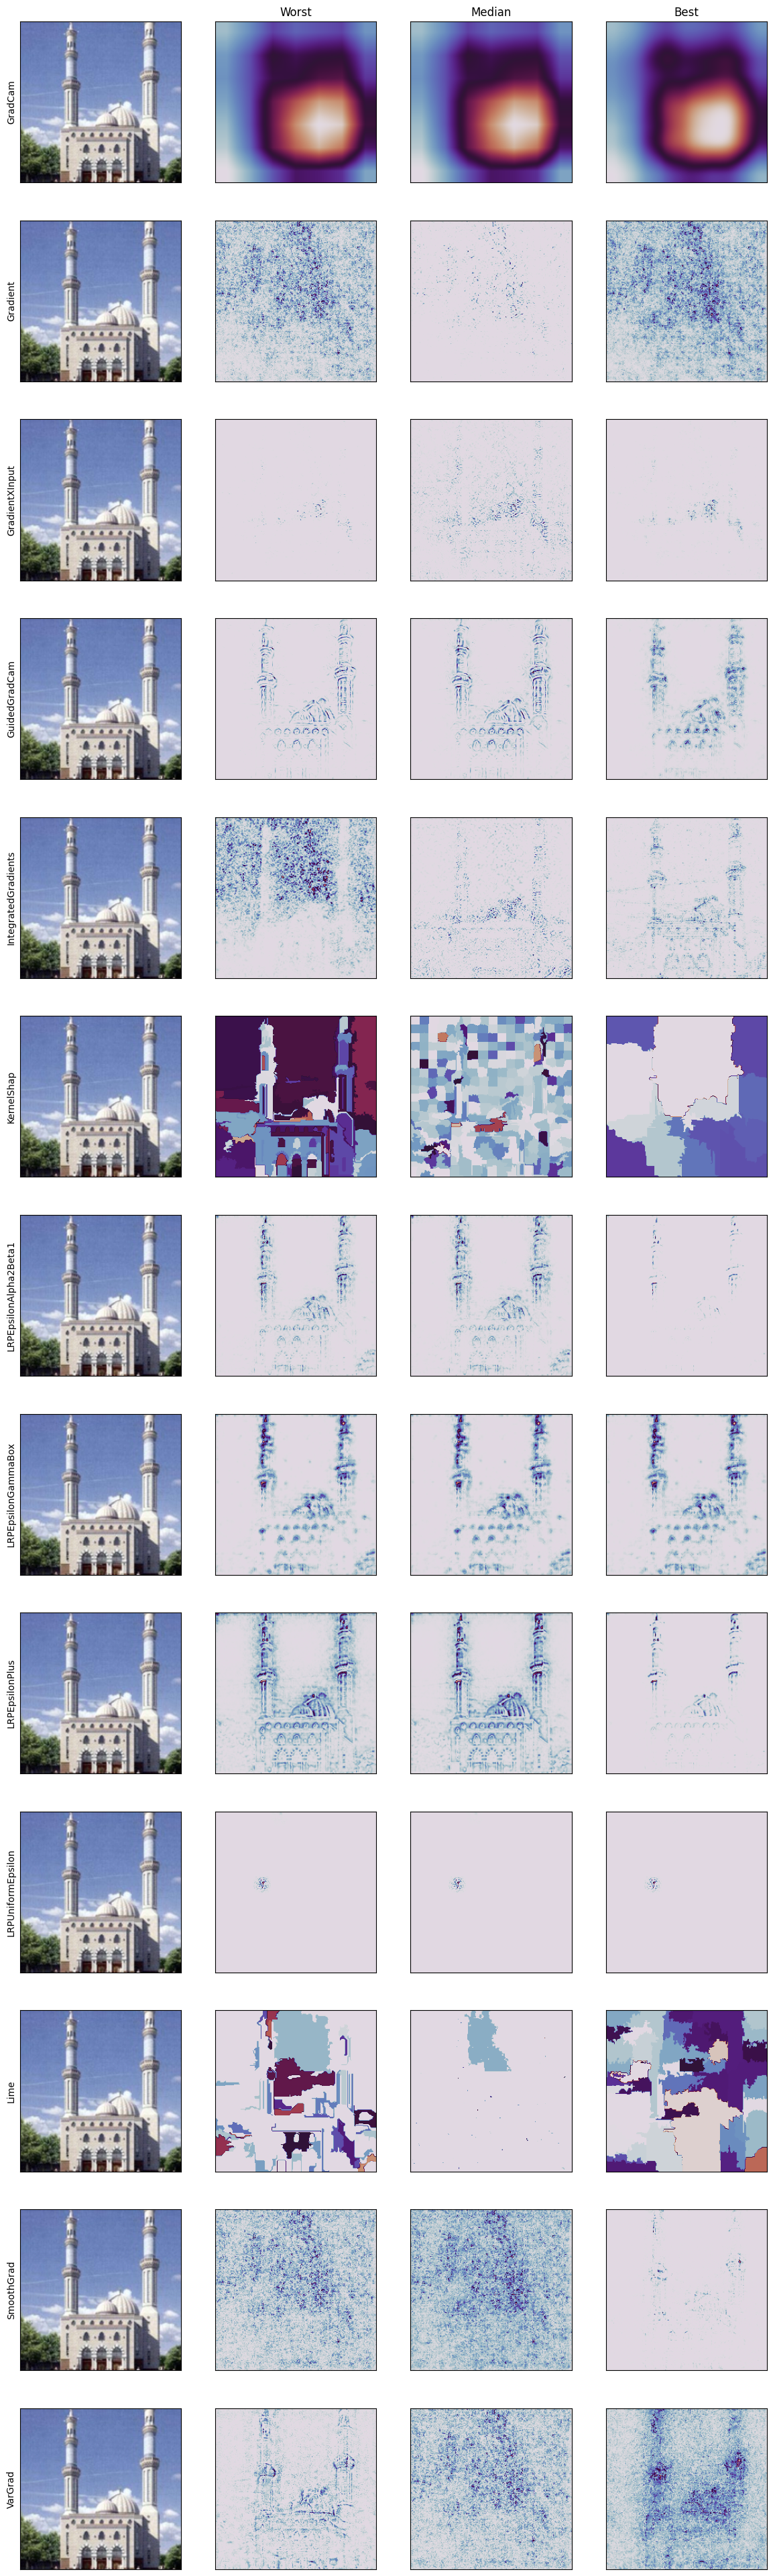

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF
from torch.utils.data._utils.collate import default_collate
from torch.utils.data import DataLoader
from pnpxai import AutoExplanationForImageClassification

from helpers import get_imagenet_dataset, get_torchvision_model, denormalize_image

import torch.nn as nn
import torch.nn.functional as F
import torchvision

# ------------------------------------------------------------------------------#
# -------------------------------- basic usage ---------------------------------#
# ------------------------------------------------------------------------------#

# setup
torch.set_num_threads(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, transform = get_torchvision_model('resnet18')
dataset = get_imagenet_dataset(transform, indices=range(1000))
loader = DataLoader(dataset, batch_size=4, shuffle=False)

# create auto explanation
expr = AutoExplanationForImageClassification(
    model=model.to(device),
    data=loader,
    input_extractor=lambda batch: batch[0].to(device),
    label_extractor=lambda batch: batch[-1].to(device),
    target_extractor=lambda outputs: outputs.argmax(-1).to(device),
    target_labels=False,  # target prediction if False
)


# browse the recommended
expr.recommended.print_tabular()  # recommendation
expr.recommended.explainers  # -> List[Type[Explainer]]

# browse explainers and metrics
expr.manager.explainers  # -> List[Explainer]
expr.manager.metrics  # -> List[Metric]

# -> Explainer. In this case, LRPEpsilonGammaBox
expr.manager.get_explainer_by_id(7)
# -> PostProcessor. In this case, PostProcessor(pooling_method='sumpos', normalization_method='minmax')
expr.manager.get_postprocessor_by_id(0)
expr.manager.get_metric_by_id(0)  # -> Metric. In this case, AbPC

# explain and evaluate
results = expr.run_batch(
    data_ids=range(4),
    explainer_id=4,
    postprocessor_id=0,
    metric_id=0,
)


#------------------------------------------------------------------------------#
#------------------------------- optimization ---------------------------------#
#------------------------------------------------------------------------------#

# user inputs
explainer_id = 4 # explainer_id to be optimized: KernelShap
metric_id = 1 # metric_id to be used as objective: AbPC
data_id = 668

# optimize: returns optimal explainer id, optimal postprocessor id, (and study)
optimized = expr.optimize(
    data_ids=data_id,
    explainer_id=explainer_id,
    metric_id=metric_id,
    direction='maximize', # less is better
    sampler='tpe', # Literal['tpe','random']
    n_trials=50, # by default, 50 for sampler in ['random', 'tpe'], None for ['grid']
    seed=42, # seed for sampler: by default, None
)

print('Best/Explainer:', optimized.explainer) # get the optimized explainer
print('Best/PostProcessor:', optimized.postprocessor) # get the optimized postprocessor
print('Best/value:', optimized.study.best_trial.value) # get the optimized value

# Every trial in study has its explainer and postprocessor in user attr.
i = 25
print(f'{i}th Trial/Explainer', optimized.study.trials[i].user_attrs['explainer']) # get the explainer of i-th trial
print(f'{i}th Trial/PostProcessor', optimized.study.trials[i].user_attrs['postprocessor']) # get the postprocessor of i-th trial
print(f'{i}th Trial/value', optimized.study.trials[i].value)

# For example, you can use optuna's API to get the explainer and postprocessor of the worst trial
def get_worst_trial(study):
    valid_trials = [trial for trial in study.trials if trial.value is not None]
    return sorted(valid_trials, key=lambda trial: trial.value)[0]

worst_trial = get_worst_trial(optimized.study)
print('Worst/Explainer:', worst_trial.user_attrs['explainer'])
print('Worst/PostProcessor', worst_trial.user_attrs['postprocessor'])
print('Worst/value', worst_trial.value)


# ------------------------------------------------------------------------------#
# ------------------------------- visualization --------------------------------#
# ------------------------------------------------------------------------------#

# plots
n_explainers = len(expr.manager.explainers)
edge_size = 3
fig, axes = plt.subplots(n_explainers, 4, figsize=(edge_size*4, edge_size*n_explainers))

for explainer_id in range(n_explainers):
    explainer_nm = expr.manager.get_explainer_by_id(explainer_id).__class__.__name__

    # optimize
    optimized = expr.optimize(
        data_ids=data_id,
        explainer_id=explainer_id,
        metric_id=metric_id,
        direction='maximize',
        sampler='random',
        n_trials=50,
        seed=42,
    )

    # prepare trials to visualize
    sorted_trials = sorted(
        [trial for trial in optimized.study.trials if trial.value is not None],
        key=lambda trial: trial.value,
    )
    trials_to_vis = {
        'Worst': sorted_trials[0],
        'Median': sorted_trials[len(sorted_trials)//2],
        'Best': sorted_trials[-1],
    }

    data = expr.manager.batch_data_by_ids(data_ids=[data_id])
    inputs = expr.input_extractor(data)
    labels = expr.label_extractor(data)

    # vis inputs
    r = explainer_id
    axes[r, 0].imshow(
        denormalize_image(
            inputs[0].detach().cpu(),
            mean=transform.mean,
            std=transform.std,
    ))
    axes[r, 0].set_ylabel(explainer_nm)

    # vis explanations
    for c, (title, trial) in enumerate(trials_to_vis.items(), 1):
        explainer = trial.user_attrs['explainer']
        postprocessor = trial.user_attrs['postprocessor']

        attrs = explainer.attribute(inputs, labels)
        pps = postprocessor(attrs)
        axes[r, c].imshow(pps[0].detach().cpu(), cmap='twilight')
        if r == 0:
            axes[r, c].set_title(title)

fig.subplots_adjust(wspace=-.5, hspace=-.5)
fig.tight_layout()

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

# plt.savefig('auto_explanation_imagenet_example.png')
plt.show()
